In [1]:
#pip install -r requirements.txt

# === IMPORTS ===
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.stattools import acf
from scipy.stats import kurtosis, gaussian_kde, rankdata, norm, genpareto, t
from sklearn.model_selection import train_test_split
from sklearn.covariance import EmpiricalCovariance
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.special import gamma
from sklearn.utils import resample
from types import SimpleNamespace
import numpy as np
from itertools import cycle
from numpy.linalg import norm  
import random
import math, itertools


In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.model_utils import power_spherical_kernel, kde_power_spherical, leave_one_out_nll, optimize_kappa, plot_kappa_optimization, sample_power_spherical, simulate_from_spar_deep, fit_and_sample_gaussian_copula, fit_and_sample_t_copula, extract_spar_tail, sample_equal_tail, resample_bulk, rebuild_equal_dataset
from src.plotting_utils import find_dense_directions, count_points_per_direction, select_points_near_direction

In [3]:
seed = 42
random.seed(seed)

In [4]:
tickers = ['GOOGL', 'AAPL', 'MSFT', 'NVDA', 'AMZN']

def generate_20_returns(tickers, start='2003-01-01', end='2025-01-01'):
    
    data = yf.download(tickers, start=start, end=end)['Close']
    
    # Compute log-returns with 20 days
    cum_returns = data / data.shift(20) - 1
    cum_returns = cum_returns.dropna()

    return cum_returns[tickers]


In [5]:
resid_df = generate_20_returns(tickers, start='1999-01-01', end='2025-01-01')


C:\Users\moad1\AppData\Local\Temp\ipykernel_19668\2244740494.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  5 of 5 completed


In [6]:
from scipy.stats import norm

# Extract the two return series
X = resid_df[tickers[0]].values
Y = resid_df[tickers[1]].values

# Equally-weighted portfolio (50% each)
portfolio = 0.5 * X + 0.5 * Y

# Radial distance and threshold (90% quantile = top 10% extremes)
r = np.sqrt(X**2 + Y**2)
threshold_r = np.quantile(r, 0.9)
mask_extreme = r > threshold_r

# === Function to prepare data for Q-Q plots ===
def prepare_qq(data):
    sorted_data = np.sort(data)
    std_data = (sorted_data - np.mean(data)) / np.std(data)
    n = len(std_data)
    osm = norm.ppf((np.arange(1, n+1) - 0.5) / n)
    return osm, std_data

osm_X, std_X = prepare_qq(X)
osm_Y, std_Y = prepare_qq(Y)
osm_portfolio, std_portfolio = prepare_qq(portfolio)

# === Figure ===
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# 1. Q-Q Plot X
axs[0, 0].scatter(osm_X, std_X, alpha=0.6, color="green")
axs[0, 0].plot([osm_X.min(), osm_X.max()], [osm_X.min(), osm_X.max()], color="black", linestyle="--")
axs[0, 0].set_title(f"Q-Q Plot {tickers[0]} vs Normal")
axs[0, 0].set_xlabel("Theoretical Quantiles")
axs[0, 0].set_ylabel("Sample Quantiles")

# 2. Q-Q Plot Y
axs[0, 1].scatter(osm_Y, std_Y, alpha=0.6, color="blue")
axs[0, 1].plot([osm_Y.min(), osm_Y.max()], [osm_Y.min(), osm_Y.max()], color="black", linestyle="--")
axs[0, 1].set_title(f"Q-Q Plot {tickers[1]} vs Normal")
axs[0, 1].set_xlabel("Theoretical Quantiles")
axs[0, 1].set_ylabel("Sample Quantiles")

# 3. Q-Q Plot for Portfolio
axs[0, 2].scatter(osm_portfolio, std_portfolio, alpha=0.6, color="purple")
axs[0, 2].plot([osm_portfolio.min(), osm_portfolio.max()],
               [osm_portfolio.min(), osm_portfolio.max()], color="black", linestyle="--")
axs[0, 2].set_title("Q-Q Plot Portfolio vs Normal")
axs[0, 2].set_xlabel("Theoretical Quantiles")
axs[0, 2].set_ylabel("Sample Quantiles")

# 4. Scatter plot X vs Y with circle highlighting tail region
axs[1, 0].scatter(X, Y, alpha=0.4, color="gray")
axs[1, 0].scatter(X[mask_extreme], Y[mask_extreme], color="red", label="Tail region")
axs[1, 0].set_title(f"Scatter {tickers[0]} vs {tickers[1]}\nTail extremes outside circle")
axs[1, 0].set_xlabel(tickers[0])
axs[1, 0].set_ylabel(tickers[1])

# Add the circle for the central region
circle = plt.Circle((0, 0), threshold_r, color='blue', fill=False, linestyle='--', linewidth=2, alpha=0.7)
axs[1, 0].add_patch(circle)
axs[1, 0].legend()

# 5. Histogram of the portfolio
axs[1, 1].hist(portfolio, bins=50, color="skyblue", edgecolor="black")
axs[1, 1].set_title("Distribution of 50/50 Portfolio")
axs[1, 1].axvline(np.quantile(portfolio, 0.99), color="red", linestyle="--", label="99% quantile")
axs[1, 1].legend()
axs[1, 2].axis('off')
         

plt.tight_layout()
plt.show()


In [7]:
def train_u_model(W, R, zeta=0.1, lr=0.001, n_epochs=5000, verbose=False, plot_loss=False):
    """
    Train the u(theta) model using quantile regression with early stopping.

    Args:
        W: np.ndarray (n_samples, d), angular directions
        R: np.ndarray (n_samples,), radial norms
        zeta: float, extreme proportion (top zeta => quantile at 1 - zeta)
        lr: float, learning rate
        n_epochs: int, number of epochs
        verbose: bool, prints Train and Val Loss every 100 epochs + early stopping info
        plot_loss: bool, plots Train vs Val Loss after training

    Returns:
        u_model: trained model
        u_values: predicted u(theta) values
        mask: bool array, mask of extremes (R > u(theta))
        R_ext, W_ext, u_ext, excesses: extreme data prepared for the SPAR model
    """

    tau = 1 - zeta
    d = W.shape[1]

    X_u = torch.tensor(W, dtype=torch.float32)
    y_u = torch.tensor(R, dtype=torch.float32)

    # Train/val split
    n_u = len(X_u)
    split_idx = int(0.8 * n_u)
    X_train_u, X_val_u = X_u[:split_idx], X_u[split_idx:]
    y_train_u, y_val_u = y_u[:split_idx], y_u[split_idx:]

    class U_MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(d, 16),
                nn.ReLU(),
                nn.Linear(16, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )

        def forward(self, theta):
            return self.net(theta).squeeze(-1)

    def pinball_loss(y, q, tau):
        t = y - q
        return torch.maximum(t * (tau - 1), t * tau).mean()

    u_model = U_MLP()
    u_optimizer = torch.optim.Adam(u_model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience = n_epochs // 20
    epochs_since_improvement = 0
    best_state_dict = None

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        u_model.train()
        pred_train = u_model(X_train_u)
        loss_train = pinball_loss(y_train_u, pred_train, tau)
        u_optimizer.zero_grad()
        loss_train.backward()
        u_optimizer.step()

        u_model.eval()
        with torch.no_grad():
            pred_val = u_model(X_val_u)
            loss_val = pinball_loss(y_val_u, pred_val, tau).item()

        train_losses.append(loss_train.item())
        val_losses.append(loss_val)

        if verbose and epoch % 100 == 0:
            print(f"[u] Epoch {epoch}, Train Loss = {loss_train.item():.4f}, Val Loss = {loss_val:.4f}")

        # Early stopping
        if loss_val < best_val_loss - 1e-5:
            best_val_loss = loss_val
            best_state_dict = u_model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    if best_state_dict is not None:
        u_model.load_state_dict(best_state_dict)

    if plot_loss:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Pinball Loss")
        plt.title(f"Training Curve for u(w) | Best Val Loss = {best_val_loss:.4f}")
        plt.legend()
        plt.grid(True, alpha=0.4)
        plt.show()

    # Final prediction
    with torch.no_grad():
        u_values = u_model(X_u).detach().numpy()

    mask = R > u_values
    R_ext = R[mask]
    W_ext = W[mask]
    u_ext = u_values[mask]
    excesses = R_ext - u_ext

    return u_model, u_values, mask, R_ext, W_ext, u_ext, excesses


In [8]:
def train_gp_model(W_ext, excesses, lr=1e-4, n_epochs=5000, verbose=False, plot_loss=False):
    """
    Train the GPNet model to estimate (sigma, xi) as a function of the direction w.

    Args:
        W_ext: ndarray (n_ext, d), extreme directions
        excesses: ndarray (n_ext,), radial excesses (R - u)
        lr: float, learning rate
        n_epochs: int
        verbose: bool, print losses during training
        plot_loss: bool, plot the loss curve after training

    Returns:
        model: trained network
    """

    d = W_ext.shape[1]
    X = torch.tensor(W_ext, dtype=torch.float32)
    y = torch.tensor(excesses, dtype=torch.float32)

    # Train/val split
    n = len(X)
    split_idx = int(0.8 * n)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    class GPNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(d, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 2)  # [log_nu, raw_xi]
            )

        def forward(self, x):
            out = self.net(x)
            nu = torch.exp(out[:, 0])  # nu > 0
            xi = 0.8 * torch.sigmoid(out[:, 1]) + 0.01  # xi ∈ [0.01, 0.81]
            sigma = nu / (xi + 1.0)
            return sigma, xi

    def gp_nll(y, sigma, xi):
        eps = 1e-8
        z = y / (sigma + eps)
        cond = xi.abs() > eps
        loglik = torch.where(
            cond,
            -torch.log(sigma + eps) - (1 + 1 / xi) * torch.log1p(xi * z + eps),
            -torch.log(sigma + eps) - z
        )
        return -loglik

    model = GPNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience = n_epochs//20
    patience_counter = 0
    best_model_state = None

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        sigma, xi = model(X_train)
        loss = gp_nll(y_train, sigma, xi).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            sigma_val, xi_val = model(X_val)
            val_loss = gp_nll(y_val, sigma_val, xi_val).mean().item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}, Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"⏹️ Early stopping triggered at epoch {epoch}")
                break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    if plot_loss:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Negative Log-Likelihood")
        plt.title(f"GP Model Training Curve | Best Val Loss = {best_val_loss:.4f}")
        plt.legend()
        plt.grid(True, alpha=0.4)
        plt.show()

    return model


In [9]:
def fit_and_sample_spar(resid_df, u_quantile=0.9, n_samples=10000, seed=42, verbose=False, plot_loss = False):
    """
    Fit the full SPAR model on a rolling window and return full simulated samples (bulk + tail).
    
    Args:
        X_window: np.ndarray (n_samples_window, d), centered and normalized data over sliding window
        u_quantile: float, quantile threshold for GP tail (default: 0.9)
        n_samples: int, total number of samples to simulate
        tail_prop: float, proportion from the SPAR tail
        seed: int

    Returns:
        X_full: np.ndarray (n_samples, d)
    """
    
    X_window = resid_df.values
    n, d = X_window.shape
    tickers = resid_df.columns.tolist()

    # Fix seeds
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Standardization
    mean_vec = X_window.mean(axis=0)
    std_vec = X_window.std(axis=0)
    X_std = (X_window - mean_vec) / std_vec

    # Compute angular and radial variables
    R = np.linalg.norm(X_std, axis=1)
    W = X_std / R[:, None]  # angular component on unit sphere
    torch.manual_seed(seed)

    # Define u_model and train (quantile regression)
    zeta = 1 - u_quantile
    u_model, u_values, mask, R_ext, W_ext, u_ext, excesses = train_u_model(W, R, zeta=zeta, lr=0.001, n_epochs=5000, verbose=verbose, plot_loss=plot_loss)
    
    # Fit GP parameter model
    
    model = train_gp_model(W_ext, excesses, lr=1e-4, n_epochs=5000, verbose=verbose, plot_loss=plot_loss)

    # KDE bandwidth estimation (quick plug-in)

    best_kappa, kappa_grid, nll_values = optimize_kappa(W_ext, m=1000, verbose=verbose)
    if plot_loss:
        plot_kappa_optimization(kappa_grid, nll_values)


    # Bulk sampling
    mask_body = ~mask
    X_body_pool = X_std[mask_body]
    n_tail = int(n_samples * zeta)
    n_body = n_samples - n_tail
    X_tail = simulate_from_spar_deep(n_samples=n_tail,model=model,u_model=u_model,w_ext=W_ext,best_kappa=best_kappa,seed=seed)
    X_body = resample(X_body_pool, n_samples=n_body, replace=True, random_state=seed)
    
    # Combine body + tail
    X_sim_std = np.vstack([X_body, X_tail])

    # Destandardize
    X_sim = X_sim_std * std_vec + mean_vec

    # Return DataFrame
    simulated_df = pd.DataFrame(X_sim, columns=tickers)
    return u_model, model, simulated_df

In [10]:


def bootstrap_train_models(W, R, zeta=0.1, B=50, lr_u=1e-4, lr_gp=1e-4,
                            n_epochs_u=1000, n_epochs_gp=1000, verbose=False):
    """
    Train B pairs of (u_model, gp_model) on bootstrapped samples.
    
    Args:
        W: np.ndarray (n_samples, d), directions
        R: np.ndarray (n_samples,), radial norms
        zeta: quantile for u(theta)
        B: number of bootstrap replications
        lr_u, lr_gp: learning rates
        n_epochs_u, n_epochs_gp: training epochs
    Returns:
        models_list: list of tuples (u_model, gp_model)
    """
    models_list = []
    for b in range(B):
        if verbose:
            print(f"[Bootstrap] Training model {b+1}/{B}")
        # Bootstrap resampling
        idx = np.random.choice(len(W), size=len(W), replace=True)
        W_b, R_b = W[idx], R[idx]

        # Train u_model
        u_model, u_values, mask, R_ext, W_ext, u_ext, excesses = train_u_model(
            W_b, R_b, zeta=zeta, lr=lr_u, n_epochs=n_epochs_u, verbose=False, plot_loss=False
        )

        # Train gp_model
        if len(W_ext) < 30:
            if verbose:
                print(f"⚠ Skipped iteration {b+1}: too few extremes")
            continue
        gp_model = train_gp_model(W_ext, excesses, lr=lr_gp, n_epochs=n_epochs_gp, verbose=False, plot_loss=False)

        models_list.append((u_model, gp_model))
    return models_list


def plot_pair_with_bootstrap(models_list, tickers, idx_a, idx_b, n_grid=360):
    """
    Evaluate and plot u, sigma, xi on a pair with bootstrap uncertainty.
    
    Args:
        models_list: list of trained (u_model, gp_model)
        tickers: list of tickers
        idx_a, idx_b: indices of the two tickers
        n_grid: number of angular points
    """
    d = len(tickers)
    theta = np.linspace(0, 2*np.pi, n_grid)

    # 2D grid in R^d
    W_grid = np.zeros((n_grid, d))
    W_grid[:, idx_a] = np.cos(theta)
    W_grid[:, idx_b] = np.sin(theta)
    W_grid /= np.linalg.norm(W_grid, axis=1, keepdims=True)

    # Bootstrap predictions
    u_preds, sigma_preds, xi_preds = [], [], []
    for u_model, gp_model in models_list:
        with torch.no_grad():
            W_tensor = torch.tensor(W_grid, dtype=torch.float32)
            u_vals = u_model(W_tensor).cpu().numpy()
            sigma_vals, xi_vals = gp_model(W_tensor)
            sigma_vals = sigma_vals.cpu().numpy()
            xi_vals = xi_vals.cpu().numpy()
        u_preds.append(u_vals)
        sigma_preds.append(sigma_vals)
        xi_preds.append(xi_vals)

    u_preds = np.array(u_preds)
    sigma_preds = np.array(sigma_preds)
    xi_preds = np.array(xi_preds)

    # Compute bootstrap statistics
    def compute_stats(arr):
        return {
            "mean": arr.mean(axis=0),
            "low": np.percentile(arr, 2.5, axis=0),
            "up": np.percentile(arr, 97.5, axis=0)
        }

    stats = {
        "u": compute_stats(u_preds),
        "sigma": compute_stats(sigma_preds),
        "xi": compute_stats(xi_preds)
    }

    # === Polar plots ===
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'polar': True})
    params = [("u", r"$u(\theta)$", 'blue'),
              ("sigma", r"$\sigma(\theta)$", 'green'),
              ("xi", r"$\xi(\theta)$", 'purple')]

    for ax, (key, label, color) in zip(axs, params):
        ax.fill_between(theta, stats[key]["low"], stats[key]["up"], color='gray', alpha=0.3, label="95% CI")
        ax.plot(theta, stats[key]["mean"], color=color, linewidth=2, label=f"{label} mean")
        global_mean = stats[key]["mean"].mean()
        ax.plot(theta, [global_mean]*len(theta), '--', color='red', linewidth=2, label=f"Global mean {label}")

        ax.set_title(f"Directional {label}", fontsize=14)
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
        ax.set_xticklabels([
            f"{tickers[idx_a]} (+)", f"{tickers[idx_b]} (+)",
            f"{tickers[idx_a]} (-)", f"{tickers[idx_b]} (-)"
        ])
        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()


In [11]:
Z = resid_df[tickers].values  
R = np.linalg.norm(Z, axis=1)
W = Z / R[:, None]

In [41]:
models_list = bootstrap_train_models(W, R, zeta=0.1, B=400, verbose=True)


[Bootstrap] Training model 1/400
[Bootstrap] Training model 2/400
[Bootstrap] Training model 3/400
[Bootstrap] Training model 4/400
[Bootstrap] Training model 5/400
[Bootstrap] Training model 6/400
[Bootstrap] Training model 7/400
[Bootstrap] Training model 8/400
[Bootstrap] Training model 9/400
[Bootstrap] Training model 10/400
[Bootstrap] Training model 11/400
[Bootstrap] Training model 12/400
[Bootstrap] Training model 13/400
[Bootstrap] Training model 14/400
[Bootstrap] Training model 15/400
[Bootstrap] Training model 16/400
[Bootstrap] Training model 17/400
[Bootstrap] Training model 18/400
[Bootstrap] Training model 19/400
[Bootstrap] Training model 20/400
[Bootstrap] Training model 21/400
[Bootstrap] Training model 22/400
[Bootstrap] Training model 23/400
[Bootstrap] Training model 24/400
[Bootstrap] Training model 25/400
[Bootstrap] Training model 26/400
[Bootstrap] Training model 27/400
[Bootstrap] Training model 28/400
[Bootstrap] Training model 29/400
[Bootstrap] Training mo

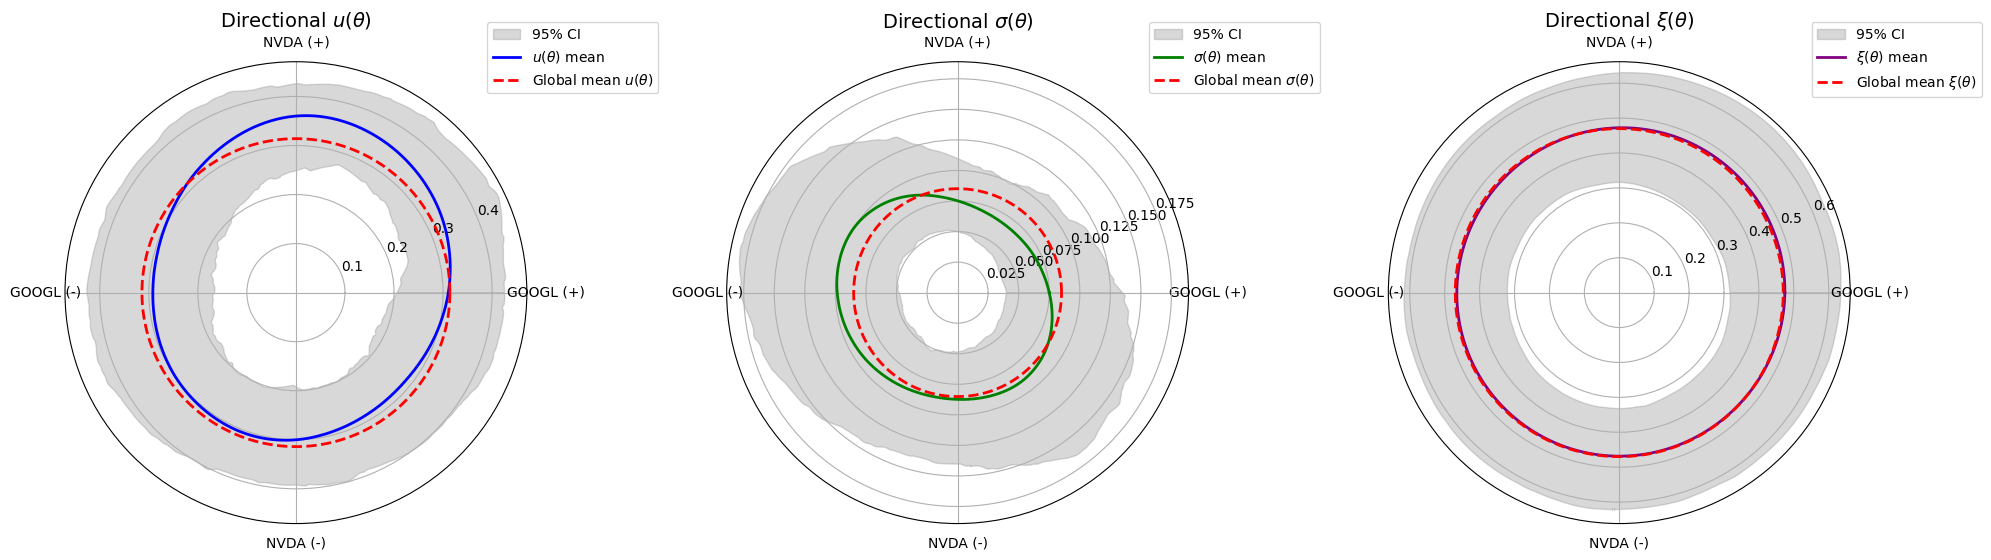

In [42]:
plot_pair_with_bootstrap(models_list, tickers, 0, 3)

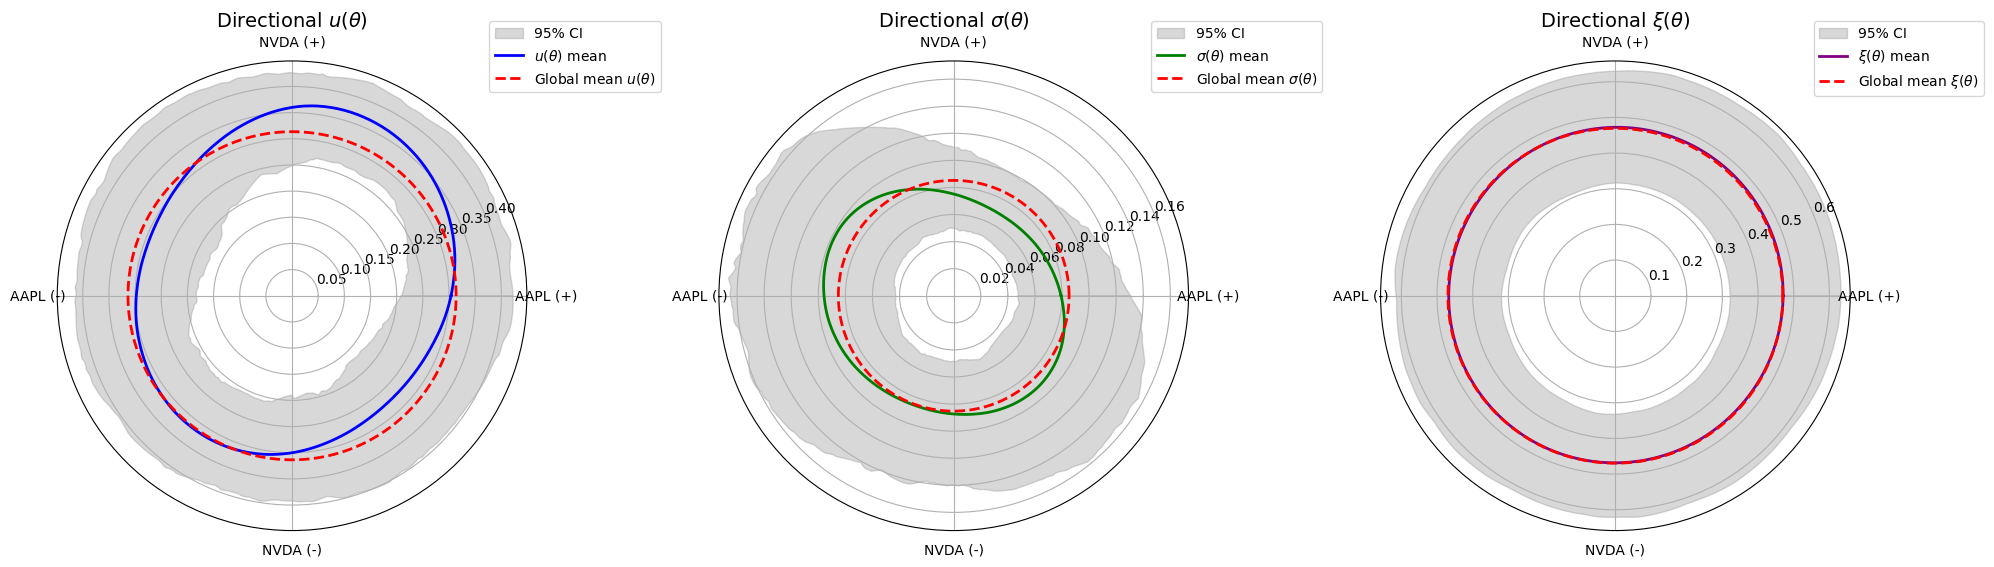

In [43]:
plot_pair_with_bootstrap(models_list, tickers, 1, 3)

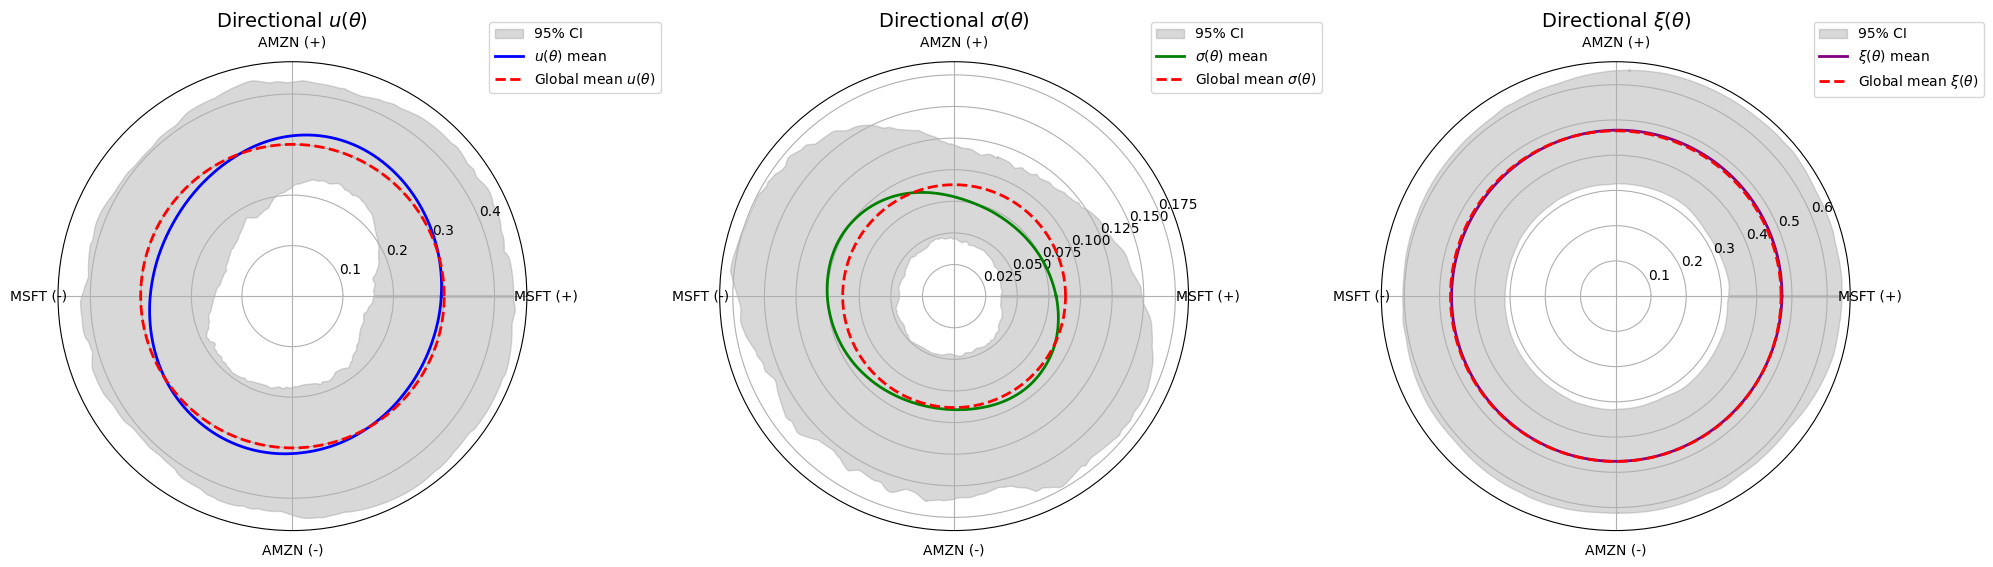

In [44]:
plot_pair_with_bootstrap(models_list, tickers, 2, 4)

In [16]:
u_quantile = 0.90
simulated_copule = fit_and_sample_gaussian_copula(resid_df, n_samples=len(resid_df))
u_model_simulation ,_, simulated_spar = fit_and_sample_spar(resid_df, n_samples=len(resid_df), u_quantile=u_quantile)
simulated_t_copule_3 = fit_and_sample_t_copula(resid_df, nu = 3, n_samples=len(resid_df))
simulated_t_copule_5 = fit_and_sample_t_copula(resid_df, nu = 5, n_samples=len(resid_df))
simulated_t_copule_10 = fit_and_sample_t_copula(resid_df, nu = 10, n_samples=len(resid_df))


c:\Users\moad1\Desktop\Summer Project\Thesis-SPAR-Code\src\model_utils.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  return C * (inner ** kappa)
c:\Users\moad1\Desktop\Summer Project\Thesis-SPAR-Code\src\model_utils.py:25: RuntimeWarning: invalid value encountered in scalar divide
  C = (4 * np.pi)**(-eta) * gamma(2 * eta + kappa) / gamma(eta + kappa)


In [17]:
def bootstrap_fit_and_sample_all_models_tail_equalized_full(
    resid_df, 
    u_quantile=0.9,
    B=30, 
    seed=42, 
    verbose=False
):
    """
    Bootstrap, fit SPAR + Copulas, simulate, and equalize tails according to SPAR's u_model.
    Bulk part is kept identical (empirical bulk) for all models.
    Stores also u_models and tails for later tail-only analysis (e.g., CDF plots).

    Returns:
        results: dict {
            "sims_dict": {model: [df_full_boot1, ..., df_full_bootB]},
            "tails_dict": {model: [df_tail_boot1, ..., df_tail_bootB]},
            "u_models": [u_model_boot1, ..., u_model_bootB],
            "tails_empirical": [df_tail_emp_boot1, ..., df_tail_emp_bootB]
        }
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    n, d = resid_df.shape
    sims_dict = { "SPAR": [], "Gaussian": [], "t3": [], "t5": [], "t10": [] }
    tails_dict = { "SPAR": [], "Gaussian": [], "t3": [], "t5": [], "t10": [] }
    u_models = []
    tails_empirical = []

    def match_tail_size(df_tail, target_size, seed):
        """Sample tail to match target size, with replacement if needed."""
        replace_flag = len(df_tail) < target_size
        return df_tail.sample(
            n=target_size,
            replace=replace_flag,
            random_state=seed
        )

    for b in range(B):
        if verbose:
            print(f"[Bootstrap] {b+1}/{B}")

        # Bootstrap resample rows
        idx = np.random.choice(n, size=n, replace=True)
        boot_df = resid_df.iloc[idx].reset_index(drop=True)

        # Fit + simulate SPAR
        u_model_simulation, _, spar_sim = fit_and_sample_spar(
            boot_df, u_quantile=u_quantile, n_samples=n, seed=seed+b
        )
        u_models.append(u_model_simulation)

        # Fit + simulate Copulas
        gauss_sim = fit_and_sample_gaussian_copula(boot_df, n_samples=n, seed=seed+b)
        t3_sim = fit_and_sample_t_copula(boot_df, nu=3, n_samples=n, seed=seed+b)
        t5_sim = fit_and_sample_t_copula(boot_df, nu=5, n_samples=n, seed=seed+b)
        t10_sim = fit_and_sample_t_copula(boot_df, nu=10, n_samples=n, seed=seed+b)

        # Extract empirical bulk & tail
        tail_emp, bulk_emp = extract_spar_tail(boot_df, u_model_simulation)
        n_tail_emp = len(tail_emp)
        tails_empirical.append(tail_emp)

        # Extract model tails using same u_model
        tail_spar, _ = extract_spar_tail(spar_sim, u_model_simulation)
        tail_gauss, _ = extract_spar_tail(gauss_sim, u_model_simulation)
        tail_t3, _ = extract_spar_tail(t3_sim, u_model_simulation)
        tail_t5, _ = extract_spar_tail(t5_sim, u_model_simulation)
        tail_t10, _ = extract_spar_tail(t10_sim, u_model_simulation)

        # Match tail size
        tail_spar = match_tail_size(tail_spar, n_tail_emp, seed+b)
        tail_gauss = match_tail_size(tail_gauss, n_tail_emp, seed+b)
        tail_t3 = match_tail_size(tail_t3, n_tail_emp, seed+b)
        tail_t5 = match_tail_size(tail_t5, n_tail_emp, seed=b)
        tail_t10 = match_tail_size(tail_t10, n_tail_emp, seed=seed+b)

        # Store tails only
        tails_dict["SPAR"].append(tail_spar)
        tails_dict["Gaussian"].append(tail_gauss)
        tails_dict["t3"].append(tail_t3)
        tails_dict["t5"].append(tail_t5)
        tails_dict["t10"].append(tail_t10)

        # Store full datasets bulk+tail
        sims_dict["SPAR"].append(pd.concat([bulk_emp, tail_spar], axis=0).reset_index(drop=True))
        sims_dict["Gaussian"].append(pd.concat([bulk_emp, tail_gauss], axis=0).reset_index(drop=True))
        sims_dict["t3"].append(pd.concat([bulk_emp, tail_t3], axis=0).reset_index(drop=True))
        sims_dict["t5"].append(pd.concat([bulk_emp, tail_t5], axis=0).reset_index(drop=True))
        sims_dict["t10"].append(pd.concat([bulk_emp, tail_t10], axis=0).reset_index(drop=True))

    return {
        "sims_dict": sims_dict,
        "tails_dict": tails_dict,
        "u_models": u_models,
        "tails_empirical": tails_empirical
    }



In [18]:
results_bootstrap = bootstrap_fit_and_sample_all_models_tail_equalized_full(
    resid_df=resid_df,
    u_quantile=0.9,
    B=25,             
    seed=42,
    verbose=True
)
    

[Bootstrap] 1/25
[Bootstrap] 2/25
[Bootstrap] 3/25
[Bootstrap] 4/25
[Bootstrap] 5/25
[Bootstrap] 6/25
[Bootstrap] 7/25
[Bootstrap] 8/25
[Bootstrap] 9/25
[Bootstrap] 10/25
[Bootstrap] 11/25
[Bootstrap] 12/25
[Bootstrap] 13/25
[Bootstrap] 14/25
[Bootstrap] 15/25
[Bootstrap] 16/25
[Bootstrap] 17/25
[Bootstrap] 18/25
[Bootstrap] 19/25
[Bootstrap] 20/25
[Bootstrap] 21/25
[Bootstrap] 22/25
[Bootstrap] 23/25
[Bootstrap] 24/25
[Bootstrap] 25/25


In [20]:
sims_dict = results_bootstrap["sims_dict"] 


In [21]:
def plot_lambda_with_ic_pairs(
    resid_df,
    sims_dict,
    pairs,
    thresholds=None,
    ci=90,
    lower=True
):
    if thresholds is None:
        thresholds = np.linspace(0.8, 0.99, 20)

    lower_q = (100 - ci) / 2
    upper_q = 100 - lower_q
    models = list(sims_dict.keys())
    lambda_symbol = r"$\lambda_L$" if lower else r"$\lambda_U$"

    n_pairs = len(pairs)
    ncols = 1               
    nrows = n_pairs         

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(7, 4 * nrows),  
        sharey=True
    )

    if n_pairs == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for ax, (i, j) in zip(axes, pairs):
        emp_vals = []
        X_emp = resid_df.iloc[:, i].values
        Y_emp = resid_df.iloc[:, j].values
        for u in thresholds:
            if lower:
                qx = np.quantile(X_emp, 1 - u)
                qy = np.quantile(Y_emp, 1 - u)
                cond = (X_emp <= qx)
                joint = cond & (Y_emp <= qy)
            else:
                qx = np.quantile(X_emp, u)
                qy = np.quantile(Y_emp, u)
                cond = (X_emp >= qx)
                joint = cond & (Y_emp >= qy)
            emp_vals.append(joint.sum() / cond.sum() if cond.sum() > 0 else np.nan)
        ax.plot(thresholds, emp_vals, color='black', lw=2, label="Empirical")

        # Models
        for model in models:
            boot_vals = []
            for df_sim in sims_dict[model]:
                X = df_sim.iloc[:, i].values
                Y = df_sim.iloc[:, j].values
                vals = []
                for u in thresholds:
                    if lower:
                        qx = np.quantile(X, 1 - u)
                        qy = np.quantile(Y, 1 - u)
                        cond = (X <= qx)
                        joint = cond & (Y <= qy)
                    else:
                        qx = np.quantile(X, u)
                        qy = np.quantile(Y, u)
                        cond = (X >= qx)
                        joint = cond & (Y >= qy)
                    vals.append(joint.sum() / cond.sum() if cond.sum() > 0 else np.nan)
                boot_vals.append(vals)

            boot_vals = np.array(boot_vals)
            mean_vals = np.nanmean(boot_vals, axis=0)
            low_vals = np.nanpercentile(boot_vals, lower_q, axis=0)
            up_vals = np.nanpercentile(boot_vals, upper_q, axis=0)

            ax.plot(thresholds, mean_vals, label=model)
            ax.fill_between(thresholds, low_vals, up_vals, alpha=0.2)

        ax.set_title(f"Pair: {resid_df.columns[i]} – {resid_df.columns[j]}")
        ax.set_xlabel("u")
        ax.set_ylabel(lambda_symbol)
        ax.grid(True)
        ax.legend(fontsize=8, loc="best")

    fig.suptitle(f"{lambda_symbol}(u) with {ci}% Bootstrap CI", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [22]:
pairs = [(0, 2),(0, 1), (0, 3)]# [(1,4), (2, 3), (2,4)]] 
plot_lambda_with_ic_pairs(
    resid_df,
    sims_dict,
    pairs=pairs
)


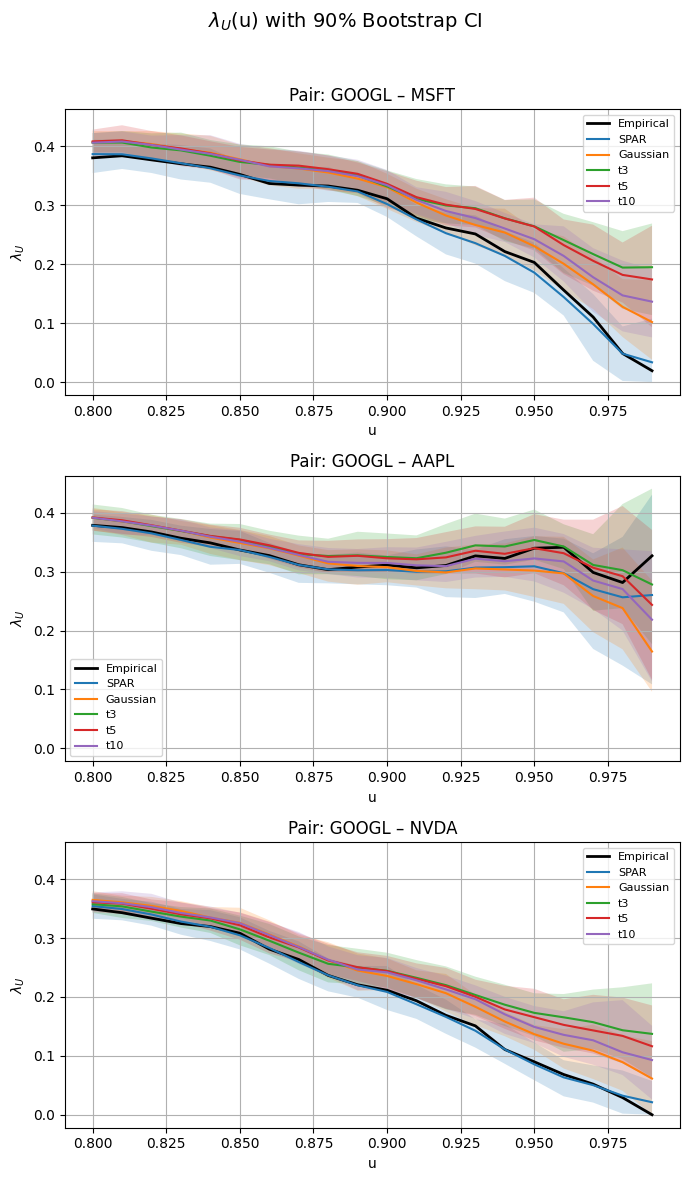

In [23]:
plot_lambda_with_ic_pairs(
    resid_df,
    sims_dict,
    pairs,
    lower = False
)

In [24]:
def plot_lambda_with_ic_pairs_full(
    resid_df,
    sims_dict,
    thresholds=None,
    ci=90,
    lower=True
):

    if thresholds is None:
        thresholds = np.linspace(0.8, 0.99, 20)

    lower_q = (100 - ci) / 2
    upper_q = 100 - lower_q
    models = list(sims_dict.keys())
    lambda_symbol = r"$\lambda_L$" if lower else r"$\lambda_U$"

    n_cols = resid_df.shape[1]
    pairs = list(itertools.combinations(range(n_cols), 2))

    n_pairs = len(pairs)
    ncols = 2   
    nrows = math.ceil(n_pairs / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(7 * ncols, 4 * nrows),
        sharey=True
    )

    axes = axes.flatten()

    for ax, (i, j) in zip(axes, pairs):
        # Empirical baseline
        emp_vals = []
        X_emp = resid_df.iloc[:, i].values
        Y_emp = resid_df.iloc[:, j].values
        for u in thresholds:
            if lower:
                qx = np.quantile(X_emp, 1 - u)
                qy = np.quantile(Y_emp, 1 - u)
                cond = (X_emp <= qx)
                joint = cond & (Y_emp <= qy)
            else:
                qx = np.quantile(X_emp, u)
                qy = np.quantile(Y_emp, u)
                cond = (X_emp >= qx)
                joint = cond & (Y_emp >= qy)
            emp_vals.append(joint.sum() / cond.sum() if cond.sum() > 0 else np.nan)
        ax.plot(thresholds, emp_vals, color='black', lw=2, label="Empirical")

        # Models
        for model in models:
            boot_vals = []
            for df_sim in sims_dict[model]:
                X = df_sim.iloc[:, i].values
                Y = df_sim.iloc[:, j].values
                vals = []
                for u in thresholds:
                    if lower:
                        qx = np.quantile(X, 1 - u)
                        qy = np.quantile(Y, 1 - u)
                        cond = (X <= qx)
                        joint = cond & (Y <= qy)
                    else:
                        qx = np.quantile(X, u)
                        qy = np.quantile(Y, u)
                        cond = (X >= qx)
                        joint = cond & (Y >= qy)
                    vals.append(joint.sum() / cond.sum() if cond.sum() > 0 else np.nan)
                boot_vals.append(vals)

            boot_vals = np.array(boot_vals)
            mean_vals = np.nanmean(boot_vals, axis=0)
            low_vals = np.nanpercentile(boot_vals, lower_q, axis=0)
            up_vals = np.nanpercentile(boot_vals, upper_q, axis=0)

            ax.plot(thresholds, mean_vals, label=model)
            ax.fill_between(thresholds, low_vals, up_vals, alpha=0.2)

        ax.set_title(f"Pair: {resid_df.columns[i]} – {resid_df.columns[j]}")
        ax.set_xlabel("u")
        ax.set_ylabel(lambda_symbol)
        ax.grid(True)
        ax.legend(fontsize=8, loc="best")

    for k in range(len(pairs), len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle(f"{lambda_symbol}(u) with {ci}% Bootstrap CI", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [25]:
plot_lambda_with_ic_pairs_full(
    resid_df,
    sims_dict,
    thresholds=None,
    ci=90,
    lower=True)


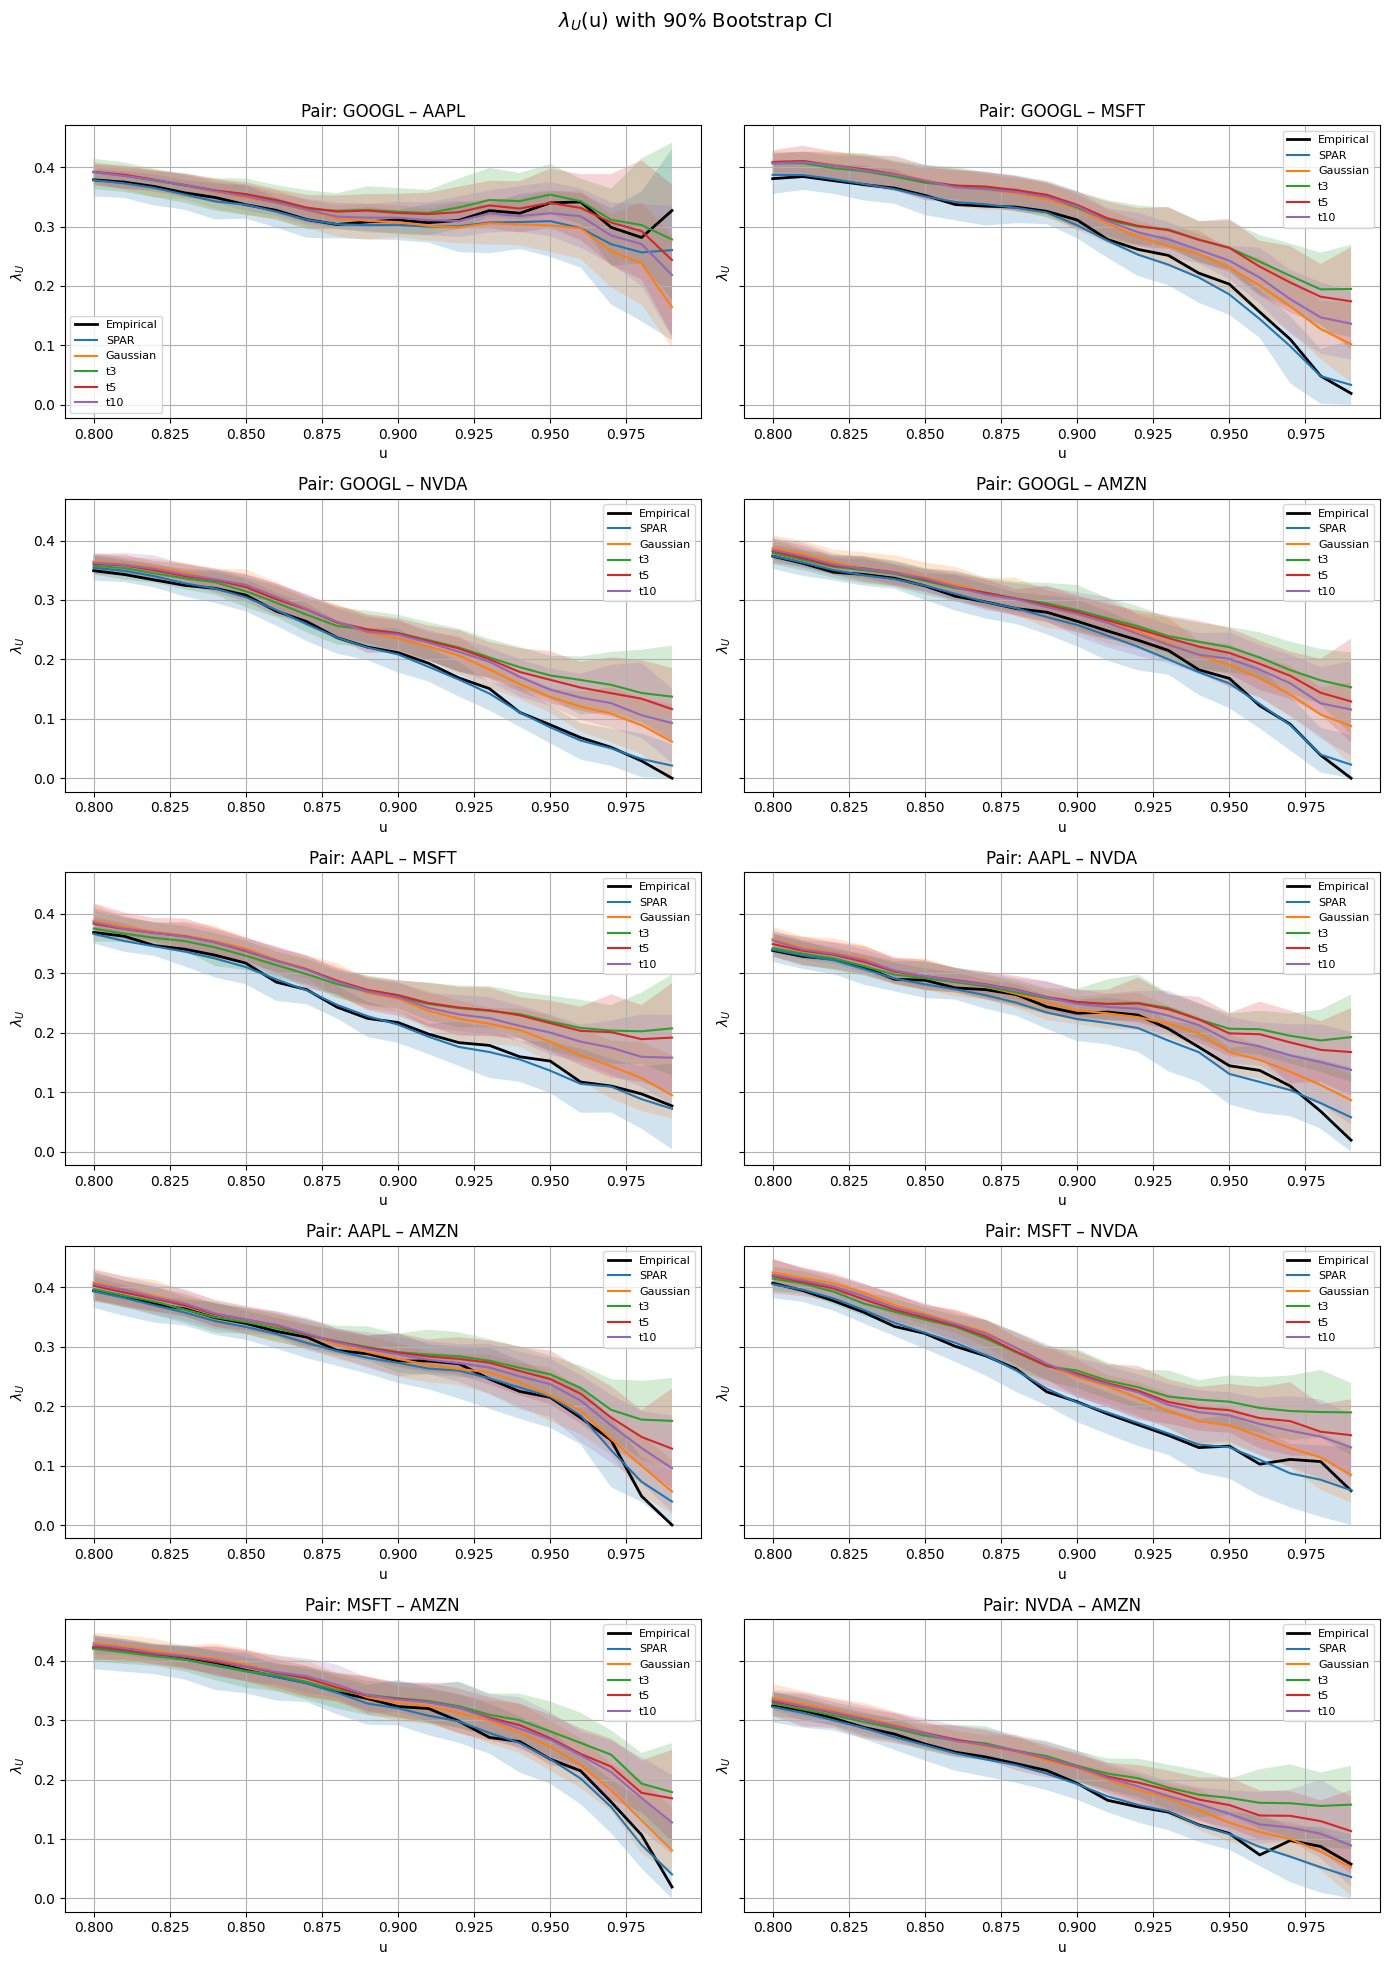

In [26]:
plot_lambda_with_ic_pairs_full(
    resid_df,
    sims_dict,
    thresholds=None,
    ci=90,
    lower=False)


In [27]:
tail_spar, _ = extract_spar_tail(simulated_spar, u_model_simulation)
tail_copula, _ = extract_spar_tail(simulated_copule, u_model_simulation)
tail_copula_t_3, _ = extract_spar_tail(simulated_t_copule_3, u_model_simulation)
tail_copula_t_5, _ = extract_spar_tail(simulated_t_copule_5, u_model_simulation)
tail_copula_t_10, _ = extract_spar_tail(simulated_t_copule_10, u_model_simulation)
dict_tail_copula_t = {
    3: tail_copula_t_3,
    5: tail_copula_t_5,
    10: tail_copula_t_10
}
tail_empirique, bulk_empirique = extract_spar_tail(resid_df, u_model_simulation)


In [28]:

n_tail_min = min(len(tail_spar), len(tail_copula), *(len(v) for v in dict_tail_copula_t.values()))
completed_empirique_resampling , resampled_tail_empirique = rebuild_equal_dataset(tail_empirique, bulk_empirique, n_tail_min)
completed_simulation_spar, sampled_tail_spar = rebuild_equal_dataset(tail_spar, bulk_empirique, n_tail_min)
completed_simulation_copula, sampled_tail_copula = rebuild_equal_dataset(tail_copula, bulk_empirique, n_tail_min)
completed_simulations_t_copula_data = {}
sampled_tails_t_copula = {}
ratio = u_quantile/(1-u_quantile)
for df, tail in dict_tail_copula_t.items():
    mixed_dataset, tail_used = rebuild_equal_dataset(tail, bulk_empirique, n_tail_min, factor = ratio)
    completed_simulations_t_copula_data[df] = mixed_dataset
    sampled_tails_t_copula[df] = tail_used

print("n_tail_min =", n_tail_min)
print("SPAR:", completed_simulation_spar.shape, "| Tail:", sampled_tail_spar.shape)
print("Copula:", completed_simulation_copula.shape, "| Tail:", sampled_tail_copula.shape)
for df in completed_simulations_t_copula_data:
    print(f"t-Copula (df={df}): mixed={completed_simulations_t_copula_data[df].shape}, tail={sampled_tails_t_copula[df].shape}")


n_tail_min = 392
SPAR: (3920, 5) | Tail: (392, 5)
Copula: (3920, 5) | Tail: (392, 5)
t-Copula (df=3): mixed=(3920, 5), tail=(392, 5)
t-Copula (df=5): mixed=(3920, 5), tail=(392, 5)
t-Copula (df=10): mixed=(3920, 5), tail=(392, 5)


In [29]:
def bootstrap_cdf(number_samples, r, x_grid, n_bootstrap=500):
    """Return an array (n_bootstrap x len(x_grid)) of bootstrap CDFs (normalized by n+1)."""
    boot_cdfs = np.empty((n_bootstrap, len(x_grid)))
    for b in range(n_bootstrap):
        sample = np.random.choice(r, size=number_samples, replace=True)
        sample.sort()
        # Normalization with n+1 to avoid sticking to 1
        boot_cdfs[b] = np.searchsorted(sample, x_grid, side='right') / (number_samples + 1)
    return boot_cdfs


def plot_cdf_direction_multi(emp_data, spar_data, copula_gauss_data, dict_copula_t, direction,
                              cos_threshold=0.95, n_bootstrap=300, alpha=0.1):
    """
    Compare Empirical, SPAR, Gaussian Copula and t-Copulas with bootstrap CIs on the CDF.
    
    Args:
        emp_data : np.ndarray (empirical data)
        spar_data : np.ndarray (SPAR)
        copula_gauss_data : np.ndarray (Gaussian Copula)
        dict_copula_t : dict {nu: np.ndarray} for t-Copulas
        direction : np.ndarray, direction of interest
        cos_threshold : float, threshold to select nearby points
        n_bootstrap : int, number of bootstrap replications
        alpha : float, significance level (0.05 → 95% CI)
    """
    # === Select points near the given direction ===
    _, r_emp = select_points_near_direction(emp_data, direction, cos_threshold)
    _, r_spar = select_points_near_direction(spar_data, direction, cos_threshold)
    _, r_gauss = select_points_near_direction(copula_gauss_data, direction, cos_threshold)

    # t-Copulas
    r_t_dict = {}
    for nu, data in dict_copula_t.items():
        _, r_t = select_points_near_direction(data, direction, cos_threshold)
        r_t_dict[nu] = r_t


    # === Define a log-spaced grid ===
    r_min = min([r_emp.min()] + [r.min() for r in [r_spar, r_gauss] + list(r_t_dict.values()) if len(r) > 0])
    r_max = max([r_emp.max()] + [r.max() for r in [r_spar, r_gauss] + list(r_t_dict.values()) if len(r) > 0])
    x_grid = np.logspace(np.log10(r_min), np.log10(r_max), len(r_emp))

    number_sample = len(r_emp)
    
    # === Bootstrap SPAR ===
    spar_boot = bootstrap_cdf(number_sample, r_spar, x_grid, n_bootstrap)
    spar_lower = np.percentile(spar_boot, 100 * alpha / 2, axis=0)
    spar_upper = np.percentile(spar_boot, 100 * (1 - alpha / 2), axis=0)
    spar_mean = spar_boot.mean(axis=0)

    # === Bootstrap Gaussian Copula ===
    gauss_boot = bootstrap_cdf(number_sample, r_gauss, x_grid, n_bootstrap)
    gauss_lower = np.percentile(gauss_boot, 100 * alpha / 2, axis=0)
    gauss_upper = np.percentile(gauss_boot, 100 * (1 - alpha / 2), axis=0)
    gauss_mean = gauss_boot.mean(axis=0)

    # === Bootstrap t-Copulas ===
    t_results = {}
    for nu, r_t in r_t_dict.items():
        t_boot = bootstrap_cdf(number_sample, r_t, x_grid, n_bootstrap)
        t_lower = np.percentile(t_boot, 100 * alpha / 2, axis=0)
        t_upper = np.percentile(t_boot, 100 * (1 - alpha / 2), axis=0)
        t_mean = t_boot.mean(axis=0)
        t_results[nu] = (t_mean, t_lower, t_upper)

    # === Plot ===
    plt.figure(figsize=(9, 6))

    # Empirical (normalized with n+1)
    emp_cdf = np.searchsorted(np.sort(r_emp), x_grid, side='right') / (len(r_emp) + 1)
    plt.plot(x_grid, emp_cdf, color='black', linewidth=2, label='Empirical')

    # SPAR + CI
    plt.fill_between(x_grid, spar_lower, spar_upper, color='red', alpha=0.25)
    plt.plot(x_grid, spar_mean, color='red', linewidth=2, label='SPAR')

    # Gaussian Copula + CI
    plt.fill_between(x_grid, gauss_lower, gauss_upper, color='blue', alpha=0.25)
    plt.plot(x_grid, gauss_mean, color='blue', linewidth=2, label='Gaussian Copula')

    # t-Copulas + CI
    color_cycle = cycle(['green', 'purple', 'orange', 'brown', 'cyan'])
    for nu, (t_mean, t_lower, t_upper) in t_results.items():
        color = next(color_cycle)
        plt.fill_between(x_grid, t_lower, t_upper, color=color, alpha=0.25)
        plt.plot(x_grid, t_mean, color=color, linewidth=2, label=f't-Copula (ν={nu})')

    # Axes & style
    plt.xscale('log')
    plt.xlabel("Radius R (log scale)")
    plt.ylabel("CDF")
    plt.title(f"CDF with {int((1-alpha)*100)}% Bootstrap CI near direction {np.round(direction, 2)} (cos≥{cos_threshold})")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [30]:
def plot_tail_fit(tail_empirique, 
                  tail_spar,
                  tail_copula,
                  tail_t_copula_3,
                  tail_t_copula_5,
                  tail_t_copula_10,
                  cos_threshold=0.7, 
                  min_points=30, 
                  nb_clusters=8):
    # Convert empirical data to numpy
    emp_data = tail_empirique.to_numpy()

    # Generate all directions
    directions = find_dense_directions(tail_empirique, K=nb_clusters)

    # Count nearby points per direction
    df = count_points_per_direction(emp_data, directions, cos_threshold=cos_threshold, min_points=min_points)

    for direction, nb_points in zip(list(df['direction']), list(df['count'])):
        print(f"Number of points: {nb_points}")
        plot_cdf_direction_multi(tail_empirique.to_numpy(),
                   tail_spar.to_numpy(),
                   tail_copula.to_numpy(),
                   {
                    3: tail_t_copula_3.to_numpy(),
                    5: tail_t_copula_5.to_numpy(),
                    10: tail_t_copula_10.to_numpy()
                    },
                   direction,
                   cos_threshold=cos_threshold)


Number of points: 127


Number of points: 119


Number of points: 78


Number of points: 63


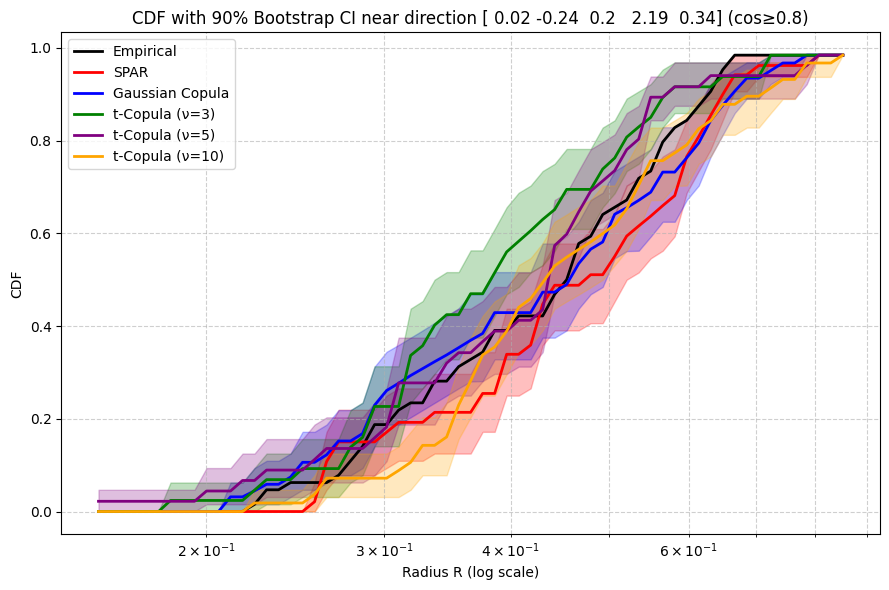

Number of points: 54


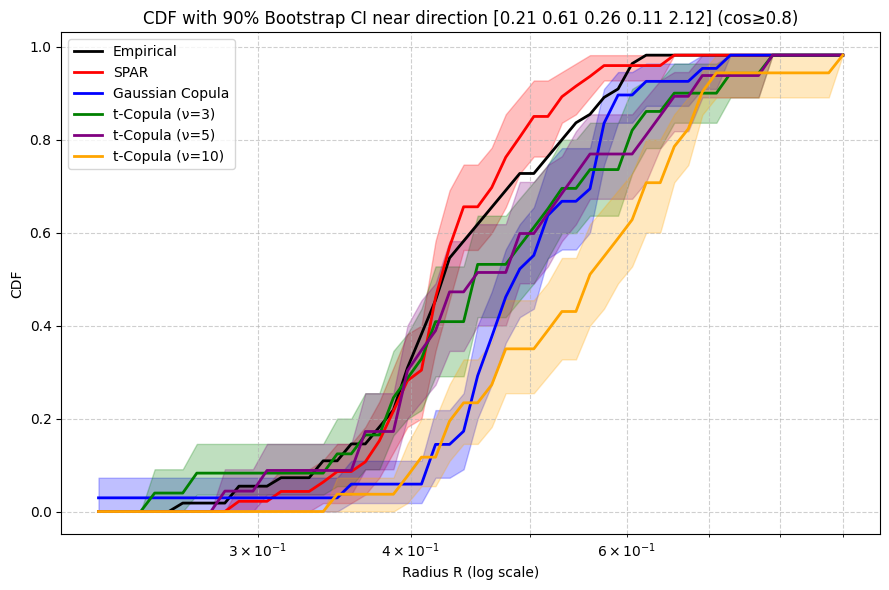

Number of points: 52


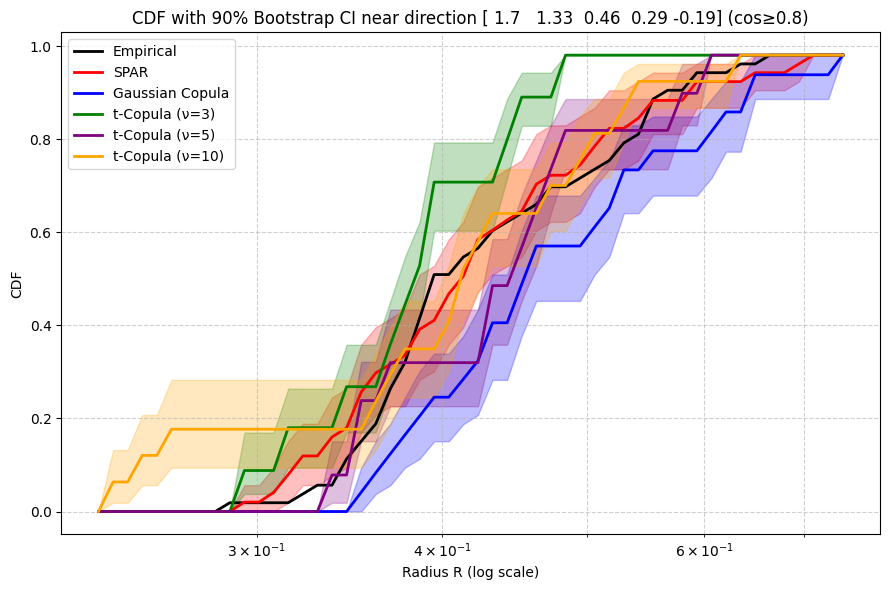

In [31]:
seed = 40
np.random.seed(seed)

plot_tail_fit(tail_empirique = tail_empirique, 
              tail_spar = sampled_tail_spar,
              tail_copula = sampled_tail_copula,
              tail_t_copula_3=sampled_tails_t_copula[3],
              tail_t_copula_5=sampled_tails_t_copula[5],
              tail_t_copula_10=sampled_tails_t_copula[10],
              cos_threshold=0.8, 
              min_points=50, 
              nb_clusters=8)

In [32]:
def bootstrap_cdf(number_samples, r, x_grid, n_bootstrap=500):
    """Return an array (n_bootstrap x len(x_grid)) of bootstrap CDFs (normalized by n+1)."""
    boot_cdfs = np.empty((n_bootstrap, len(x_grid)))
    for b in range(n_bootstrap):
        sample = np.random.choice(r, size=number_samples, replace=True)
        sample.sort()
        boot_cdfs[b] = np.searchsorted(sample, x_grid, side='right') / (number_samples + 1)
    return boot_cdfs


def plot_cdf_spar_vs_t3(emp_data, spar_data, t3_data, direction,
                        cos_threshold=0.95, n_bootstrap=300, alpha=0.05):
    """
    Compare Empirical, SPAR, and t-Copula (ν=3) with bootstrap CIs on the CDF.
    
    Args:
        emp_data : np.ndarray (empirical points)
        spar_data : np.ndarray (SPAR simulated points)
        t3_data : np.ndarray (t-Copula ν=3 simulated points)
        direction : np.ndarray, direction of interest
        cos_threshold : float, cosine threshold to select nearby points
        n_bootstrap : int, number of bootstrap replications
        alpha : float, significance level (0.05 → 95% CI)
    """
    # === Select points ===
    _, r_emp = select_points_near_direction(emp_data, direction, cos_threshold)
    _, r_spar = select_points_near_direction(spar_data, direction, cos_threshold)
    _, r_t3   = select_points_near_direction(t3_data, direction, cos_threshold)

    # Check if enough empirical points are available
    if len(r_emp) < 10:
        print(f"⚠ Too few points in direction {direction}. Skipped.")
        return

    # === Define a log-spaced grid ===
    r_min = min([r_emp.min(), r_spar.min(), r_t3.min()])
    r_max = max([r_emp.max(), r_spar.max(), r_t3.max()])
    x_grid = np.logspace(np.log10(r_min), np.log10(r_max), len(r_emp))

    number_sample = len(r_emp)

    # === Empirical CDF (normalized by n+1) ===
    emp_cdf = np.searchsorted(np.sort(r_emp), x_grid, side='right') / (len(r_emp) + 1)

    # === Bootstrap SPAR ===
    spar_boot = bootstrap_cdf(number_sample, r_spar, x_grid, n_bootstrap)
    spar_lower = np.percentile(spar_boot, 100 * alpha / 2, axis=0)
    spar_upper = np.percentile(spar_boot, 100 * (1 - alpha / 2), axis=0)
    spar_mean  = spar_boot.mean(axis=0)

    # === Bootstrap t-Copula ν=3 ===
    t3_boot = bootstrap_cdf(number_sample, r_t3, x_grid, n_bootstrap)
    t3_lower = np.percentile(t3_boot, 100 * alpha / 2, axis=0)
    t3_upper = np.percentile(t3_boot, 100 * (1 - alpha / 2), axis=0)
    t3_mean  = t3_boot.mean(axis=0)

    # === Plot ===
    plt.figure(figsize=(9, 6))

    # Empirical
    plt.plot(x_grid, emp_cdf, color='black', linewidth=2, label='Empirical')

    # SPAR
    plt.fill_between(x_grid, spar_lower, spar_upper, color='red', alpha=0.2)
    plt.plot(x_grid, spar_mean, color='red', linewidth=2, label='SPAR')

    # t-Copula ν=3
    plt.fill_between(x_grid, t3_lower, t3_upper, color='green', alpha=0.2)
    plt.plot(x_grid, t3_mean, color='green', linewidth=2, label='t-Copula (ν=3)')

    # Axes & style
    plt.xscale('log')
    plt.xlabel("Radius R (log scale)")
    plt.ylabel("Conditional CDF")
    plt.title(f"CDF with {(1-alpha)*100:.0f}% Bootstrap CI")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_tail_fit_simple_spar_t3(tail_empirique, 
                                 tail_spar,
                                 tail_t3,
                                 cos_threshold=0.7, 
                                 min_points=30, 
                                 nb_clusters=8,
                                 n_bootstrap=300,
                                 alpha=0.05):
    """
    Plot conditional CDFs for multiple dense directions 
    (Empirical, SPAR, t-Copula ν=3).
    
    Args:
        tail_empirique : DataFrame or ndarray (empirical points)
        tail_spar : DataFrame or ndarray (SPAR simulated points)
        tail_t3 : DataFrame or ndarray (t-Copula ν=3 simulated points)
        cos_threshold : float, cosine threshold to select points close to a direction
        min_points : int, minimum number of points required to plot the CDF
        nb_clusters : int, number of dense directions to explore
        n_bootstrap : int, number of bootstrap replications for CI
        alpha : float, significance level (0.05 → 95% CI)
    """
    # Convert DataFrame -> numpy if needed
    emp_data  = tail_empirique.to_numpy() if hasattr(tail_empirique, "to_numpy") else tail_empirique
    spar_data = tail_spar.to_numpy() if hasattr(tail_spar, "to_numpy") else tail_spar
    t3_data   = tail_t3.to_numpy() if hasattr(tail_t3, "to_numpy") else tail_t3

    # Find dense directions in empirical data
    directions = find_dense_directions(tail_empirique, K=nb_clusters)

    # Count points per direction
    df = count_points_per_direction(emp_data, directions, cos_threshold=cos_threshold, min_points=min_points)

    for direction, nb_points in zip(df['direction'], df['count']):
        if nb_points < min_points:
            print(f"Too few points ({nb_points}) for direction {direction}. Skipped.")
            continue

        print(f"Direction: {np.round(direction, 2)}, Number of points: {nb_points}")
        plot_cdf_spar_vs_t3(
            emp_data=emp_data,
            spar_data=spar_data,
            t3_data=t3_data,
            direction=direction,
            cos_threshold=cos_threshold,
            n_bootstrap=n_bootstrap,
            alpha=alpha
        )


Direction: [-0.66 -0.61 -0.48 -1.78 -0.9 ], Number of points: 142


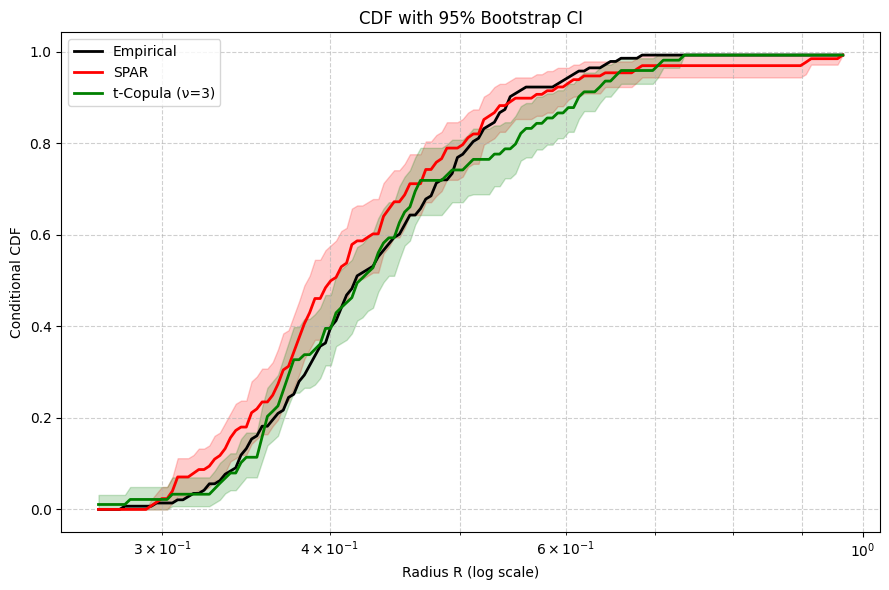

Direction: [-1.11 -1.24 -0.68 -0.79 -1.06], Number of points: 139


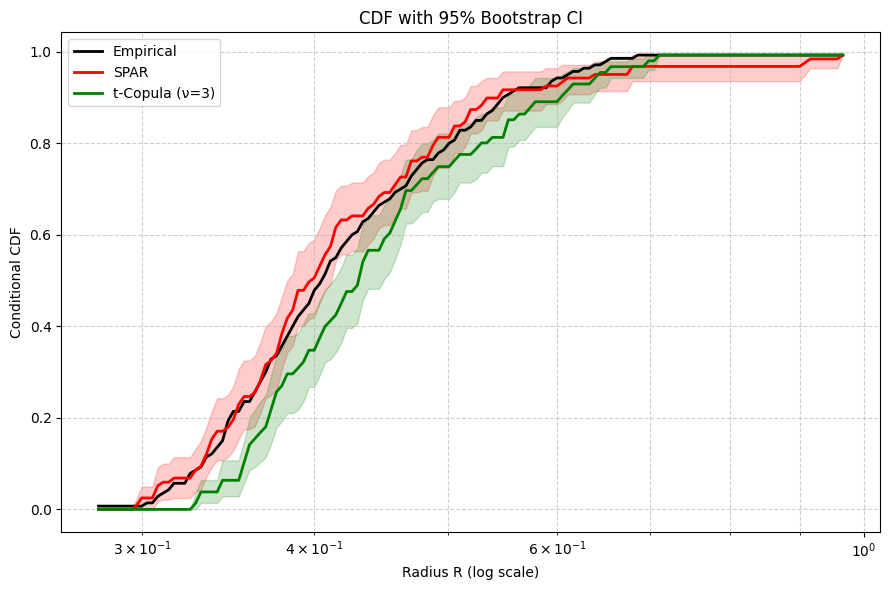

Direction: [0.48 0.94 0.86 1.46 1.  ], Number of points: 121


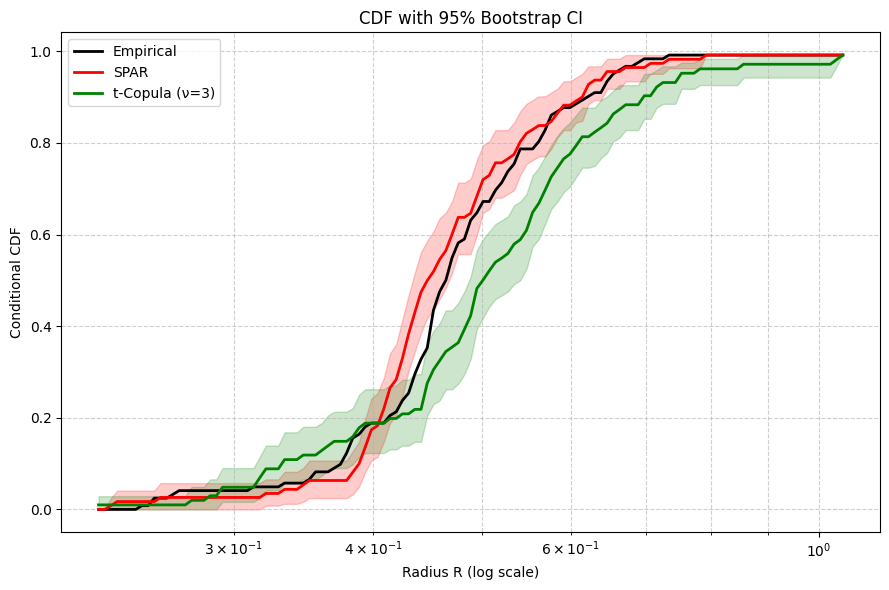

Direction: [ 0.02 -0.24  0.2   2.19  0.34], Number of points: 83


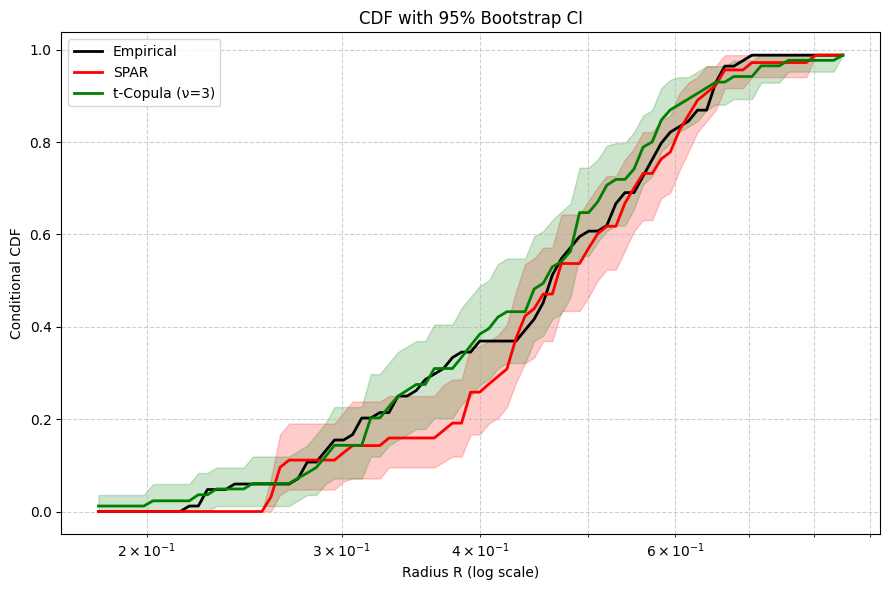

Direction: [0.21 0.61 0.26 0.11 2.12], Number of points: 71


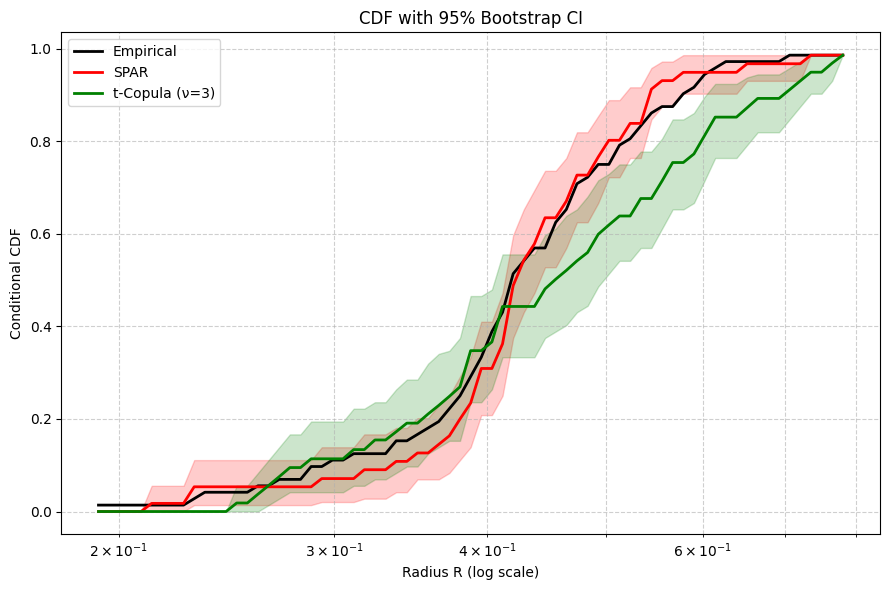

Direction: [ 1.7   1.33  0.46  0.29 -0.19], Number of points: 69


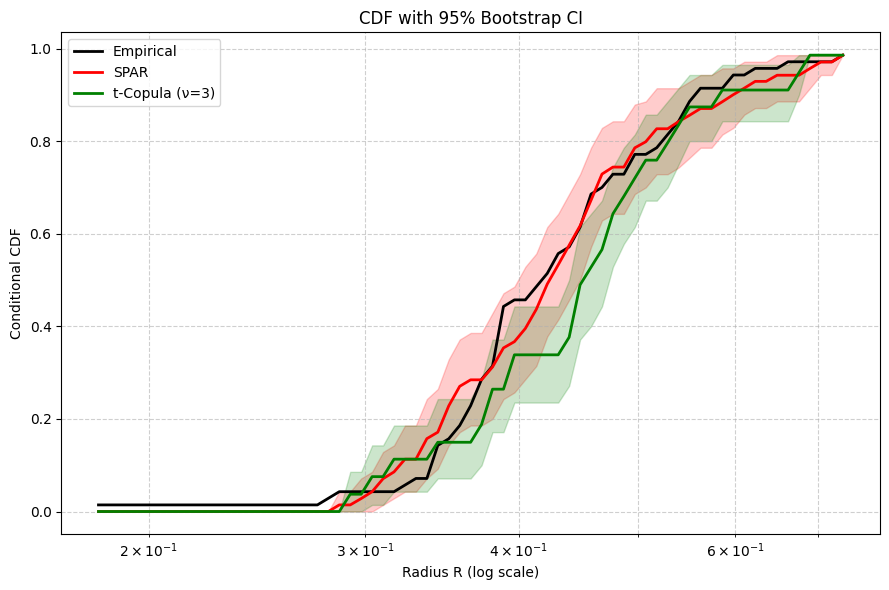

In [33]:
seed = 40
np.random.seed(seed)

plot_tail_fit_simple_spar_t3(tail_empirique = tail_empirique, 
                        tail_spar = sampled_tail_spar,
                        tail_t3 = sampled_tails_t_copula[3],
                        cos_threshold=0.7, 
                        min_points=50, 
                        nb_clusters=8,
                        n_bootstrap=500,
                        alpha=0.05)


In [35]:
def compute_loss_with_ci(mixed_models, alpha_levels=[0.95, 0.975, 0.99], 
                         portfolio_weights=None, resid_df_test=None,
                         bootstrap_B=500, ci=0.95, decimals=4):
    """
    Compute Loss(α) = magnitude (positive) of the average loss beyond VaR,
    with bootstrap confidence intervals.

    Args:
        mixed_models : dict {model_name: {"data": np.ndarray or DataFrame}}
        alpha_levels : list of alpha confidence levels
        portfolio_weights : vector of weights (if None, equally weighted)
        resid_df_test : reference size for bootstrap (optional)
        bootstrap_B : number of bootstrap resamples
        ci : confidence level
        decimals : number of decimals for rounding

    Returns:
        DataFrame with Loss and CI bounds
    """
    results = []
    ci_low = (1 - ci) / 2 * 100
    ci_high = 100 - (1 - ci) / 2 * 100

    if resid_df_test is not None:
        n_empirical = len(resid_df_test)
    else:
        n_empirical = None

    for model_name, model_dict in mixed_models.items():
        data = model_dict["data"]
        if isinstance(data, pd.DataFrame):
            data = data.values

        d = data.shape[1]
        if portfolio_weights is None:
            portfolio_weights = np.ones(d) / d

        pnl = data @ portfolio_weights
        pnl_sorted = np.sort(pnl)

        model_results = {"Model": model_name}

        for alpha in alpha_levels:
            # VaR (quantile threshold)
            var_alpha = np.quantile(pnl_sorted, 1 - alpha)
            tail_losses = pnl[pnl <= var_alpha]
            
            # Positive Loss = -mean of losses
            loss_alpha = -tail_losses.mean() if len(tail_losses) > 0 else np.nan

            # Bootstrap
            loss_boot = []
            for _ in range(bootstrap_B):
                sample_size = n_empirical if n_empirical is not None else len(pnl)
                pnl_boot = np.random.choice(pnl, size=sample_size, replace=True)
                var_b = np.quantile(pnl_boot, 1 - alpha)
                tail_b = pnl_boot[pnl_boot <= var_b]
                loss_b = -tail_b.mean() if len(tail_b) > 0 else np.nan
                loss_boot.append(loss_b)

            loss_ci = np.percentile(loss_boot, [ci_low, ci_high])

            # Rounding and storing
            model_results[f"Loss_{alpha}"] = round(loss_alpha, decimals)
            model_results[f"Loss_LB_{alpha}"] = round(loss_ci[0], decimals)
            model_results[f"Loss_UB_{alpha}"] = round(loss_ci[1], decimals)

        results.append(model_results)

    return pd.DataFrame(results)


In [36]:
mixed_models = {
    "Empirical": {"data": resid_df, "tail": tail_empirique},  
    "SPAR": {"data": completed_simulation_spar, "tail": sampled_tail_spar},
    "Gaussian Copula": {"data": completed_simulation_copula, "tail": sampled_tail_copula},
    "t-Copula ν=3": {"data": completed_simulations_t_copula_data[3], "tail": sampled_tails_t_copula[3]},
    "t-Copula ν=5": {"data": completed_simulations_t_copula_data[5], "tail": sampled_tails_t_copula[5]},
    "t-Copula ν=10": {"data": completed_simulations_t_copula_data[10], "tail": sampled_tails_t_copula[10]}
}

def plot_loss_curves(loss_results_df, alpha_levels):
    """
    Plot Loss(α) for each model with bootstrap confidence intervals.
    
    Args:
        loss_results_df : DataFrame containing the results 
                          (columns: Loss_α, Loss_LB_α, Loss_UB_α)
        alpha_levels : list of tested alpha levels (e.g., [0.95, 0.975, 0.99])
    """
    plt.figure(figsize=(8, 6))

    for _, row in loss_results_df.iterrows():
        model = row["Model"]
        loss_means = [row[f"Loss_{alpha}"] for alpha in alpha_levels]
        loss_lower = [row[f"Loss_LB_{alpha}"] for alpha in alpha_levels]
        loss_upper = [row[f"Loss_UB_{alpha}"] for alpha in alpha_levels]

        # Curve
        plt.plot(alpha_levels, loss_means, marker='o', label=model)
        # Confidence band
        plt.fill_between(alpha_levels, loss_lower, loss_upper, alpha=0.2)

    plt.xlabel("Risk Level α")
    plt.ylabel("Loss")
    plt.title("Loss as a function of α with Bootstrap Confidence Intervals")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [37]:
alpha_levels = np.linspace(0.95,0.999,25)

loss_results_df = compute_loss_with_ci(mixed_models, alpha_levels, resid_df_test=resid_df, bootstrap_B=500)


In [38]:
loss_results_df

Model  Loss_0.95  Loss_LB_0.95  Loss_UB_0.95  \
0        Empirical     0.1495        0.1418        0.1575   
1             SPAR     0.1551        0.1475        0.1623   
2  Gaussian Copula     0.1376        0.1321        0.1429   
3     t-Copula ν=3     0.1410        0.1336        0.1476   
4     t-Copula ν=5     0.1331        0.1273        0.1388   
5    t-Copula ν=10     0.1327        0.1269        0.1377   

   Loss_0.9520416666666667  Loss_LB_0.9520416666666667  \
0                   0.1515                      0.1432   
1                   0.1568                      0.1490   
2                   0.1390                      0.1333   
3                   0.1430                      0.1355   
4                   0.1345                      0.1281   
5                   0.1341                      0.1282   

   Loss_UB_0.9520416666666667  Loss_0.9540833333333333  \
0                      0.1584                   0.1534   
1                      0.1654                   0.1591   
2                      0.1443                   0.1404   
3                      0.1501                   0.1448   
4                      0.1403                   0.1358   
5                      0.1397                   0.1355   

   Loss_LB_0.9540833333333333  Loss_UB_0.9540833333333333  ...  \
0                      0.1461                      0.1602  ...   
1                      0.1502                      0.1676  ...   
2                      0.1341                      0.1464  ...   
3                      0.1371                      0.1520  ...   
4                      0.1298                      0.1419  ...   
5                      0.1293                      0.1409  ...   

   Loss_UB_0.992875  Loss_0.9949166666666667  Loss_LB_0.9949166666666667  \
0            0.2425                   0.2405                      0.2238   
1            0.2612                   0.2564                      0.2283   
2            0.2135                   0.2118                      0.1971   
3            0.2370                   0.2357                      0.2161   
4            0.2154                   0.2168                      0.1994   
5            0.2109                   0.2094                      0.1921   

   Loss_UB_0.9949166666666667  Loss_0.9969583333333334  \
0                      0.2526                   0.2534   
1                      0.2811                   0.2824   
2                      0.2250                   0.2285   
3                      0.2497                   0.2518   
4                      0.2286                   0.2300   
5                      0.2240                   0.2270   

   Loss_LB_0.9969583333333334  Loss_UB_0.9969583333333334  Loss_0.999  \
0                      0.2367                      0.2681      0.2758   
1                      0.2445                      0.3213      0.3598   
2                      0.2087                      0.2432      0.2470   
3                      0.2310                      0.2680      0.2808   
4                      0.2125                      0.2426      0.2543   
5                      0.2042                      0.2452      0.2561   

   Loss_LB_0.999  Loss_UB_0.999  
0         0.2511         0.2882  
1         0.2713         0.3933  
2         0.2326         0.2538  
3         0.2489         0.2950  
4         0.2278         0.2648  
5         0.2237         0.2701  

[6 rows x 76 columns]

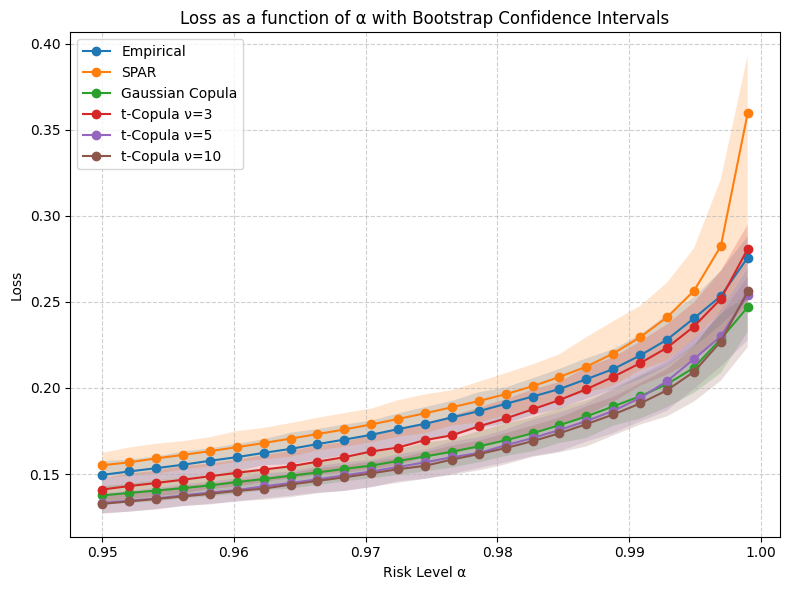

In [39]:
plot_loss_curves(loss_results_df, alpha_levels)
